# Utilisation Visualizations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from glob import glob
plt.style.use('ggplot')

plt.set_cmap('tab10')

<Figure size 640x480 with 0 Axes>

In [2]:
PLUGS_PER_CLUSTER = {
    'WEBSTER': 6,
    'BRYANT': 9,
    'HIGH': 8,
    'HAMILTON': 3,
    'CAMBRIDGE': 10,
    'MPL': 6,
    'RINCONADA': 3,
    'TED': 8
}

## Data preprocessing

### Define which cluster and model to use

In [3]:
model = 'TGCN'

### Load predictions by models trained on censoring strategies

In [4]:
def add_censoring_strategy_predictions(df=None, censoring_level=1, censoring_strategy="Static", forecast_lead=1, keep_obs=False, aware=True, cluster=None, covariates=False):
    directory_path = f"../predictions/forecast_{forecast_lead}_{'aware' if aware else 'unaware'}{'_covariates' if covariates else ''}_{model.lower()}_{censoring_strategy.lower()}_{censoring_level}"
    if not os.path.exists(directory_path):
        raise NotADirectoryError(directory_path)
    
    if cluster is None:
        raise ValueError("Cluster cannot be None")

    preds_path = glob(f"{directory_path}/predictions_{model}_{cluster}*.csv")[0] 
    df_preds = pd.read_csv(preds_path, parse_dates=["Date"], index_col=0)

    # We have to shift date with forecast lead normalized to 30 minutes
    df_preds.index = df_preds.index + pd.DateOffset(minutes=30*(forecast_lead-1))

    # Because we HAD a bug of double predictions being generated
    df_preds.dropna(inplace=True, how='all')

    # Assume we have forecast horizon of 1. Then we rename the columns to something more readable
    df_preds.rename(columns={
        cluster+"_1": f"Censored Observations {censoring_strategy} {censoring_level}",
        cluster+"_1_pred": f"Predicted {censoring_strategy} {censoring_level}",
        f"{cluster}_1_true": "True Observations"
    }, inplace=True)

    df_preds["No. Plugs per Hub"] = PLUGS_PER_CLUSTER[cluster]
    df_preds["Cluster"] = cluster

    if not keep_obs:
        df_preds = df_preds.drop(["True Observations", "No. Plugs per Hub", "Cluster"], axis=1)

    if df is None:
        return df_preds
    return df.merge(df_preds, on="Date")

### Visualization functions

In [5]:
get_relevant_cols = lambda censoring_level, censoring_strategy: [
        'Date', 'No. Plugs per Hub', "True Observations",
        f"Censored Observations {censoring_strategy} {censoring_level}", f"Predicted {censoring_strategy} {censoring_level}"]

def plot_predictions(df, censoring_level, censoring_strategy):
    # Keep only relevant columns
    df_plot = df.copy()[get_relevant_cols(censoring_level, censoring_strategy)]

    cluster = df.Cluster.unique()[0]
    
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.axhline(y=df_plot[df_plot.Date < '2019-05-30'][f'Censored Observations {censoring_strategy} {censoring_level}'].max(), linestyle='--', label='Censored Threshold', color='black', )
    df_plot[df_plot.Date < '2019-05-30']\
        .drop('No. Plugs per Hub', axis=1)\
        .drop(f"Censored Observations {censoring_strategy} {censoring_level}", axis=1)\
        .plot(x="Date", ax=ax, title=f"{model} Predictions for {cluster} cluster with censoring strategy {censoring_strategy} {censoring_level}", ylabel='Number of sessions', colormap='tab10')

    # Set horizontal line at the maximum number of plugs
    ax.legend()
    fig.savefig(f"../Figures/prediction_timeseries_{model}_{cluster}_{censoring_strategy}_{censoring_level}.png")
    plt.show()

In [6]:
def plot_daily_max_sessions(df, censoring_level, censoring_strategy):
    cluster = df.Cluster.unique()[0]
    df_plot = df.copy()[get_relevant_cols(censoring_level, censoring_strategy)]
    # Plot the highest prediction for each day, together with the highest recorded simultaneous number of sessions in a time interval
    fig, ax = plt.subplots(figsize=(20, 7))
    ax.axhline(y=df_plot[df_plot.Date < '2019-05-30'][f'Censored Observations {censoring_strategy} {censoring_level}'].max(), linestyle='--', label='Censored Threshold', color='black', )
    df_plot\
        .drop('No. Plugs per Hub', axis=1) \
        .drop(f"Censored Observations {censoring_strategy} {censoring_level}", axis=1) \
        .groupby(df_plot["Date"].dt.date).max() \
        .plot(x="Date", ax=ax, title=f"Max number of sessions for each day in cluster {cluster}", colormap='tab10')
    ax.set_title(f"Max number of sessions for each day in cluster {cluster}")
    ax.set_ylabel("Number of sessions")
    plt.show()

In [7]:
def plot_utilisation_per_day(df, censoring_level, censoring_strategy):
    cluster = df.Cluster.unique()[0]
    df_util_plot = df.copy()
    cols = get_relevant_cols(censoring_level, censoring_strategy)
    cols.remove('Date')
    cols.remove('No. Plugs per Hub')
    # We should provide tau from the model training
    for col in cols:
        df_util_plot['tau_'+col] = df_util_plot[col].max()

    sessions_per_day = df_util_plot.groupby(df_util_plot["Date"].dt.date).sum().copy()

    # Calculate utilisation
    for col in cols:
        sessions_per_day['utilisation_'+col] = sessions_per_day[col] / sessions_per_day['No. Plugs per Hub']
    # drop all tau columns
    sessions_per_day = sessions_per_day[sessions_per_day.columns[sessions_per_day.columns.str.startswith('utilisation_')]]
    # remove utilisation_ from the column names
    sessions_per_day.columns = sessions_per_day.columns.str.replace('utilisation_', '')
    fig, ax = plt.subplots(figsize=(15, 5))
    sessions_per_day.plot(ax=ax, colormap='tab10')

    ax.set_title(f"Utilisation per day in cluster {cluster}")
    ax.set_ylabel("Utilisation")
    fig.savefig(f"../Figures/daily_utilisation_{model}_{cluster}_{censoring_strategy}_{censoring_level}.png")

### Utilisation functions

In [8]:
def calculate_utility(df, max_tau, censoring_level, censoring_strategy, mean=True):
    """ 
    Calulcate the utility for a given cluster, given predictions, censored and true values of usage, for taus from 1 - max_tau.
    """
    cols = get_relevant_cols(censoring_level, censoring_strategy)
    cols.remove('Date')
    cols.remove('No. Plugs per Hub')
    util_values = {level: [] for level in cols}
    # calculate the utility for predicted usage, true usage and censored usage, for each tau
    for level, util_list in util_values.items():
        for tau_hypothetical in range(1, max_tau + 1):
            df_util = df.copy()
            # clip the values to the hypothetical tau (we use values from df instead of df_util to avoid clipping the values multiple times)
            df_util[level] = df[level].clip(upper=tau_hypothetical)
            # add the tau_hypothetical as a column
            df_util[f'tau_{tau_hypothetical}'] = tau_hypothetical
            # Sum the half-hourly values to get the daily values
            tmp = df_util.groupby(df_util["Date"].dt.date)[[level, f'tau_{tau_hypothetical}']].sum()
            # calculate the utility per day
            tmp['utilisation'] = (tmp[level] / tmp[f'tau_{tau_hypothetical}'])
            # add the mean utility to the list
            if mean:
                util_list.append(tmp['utilisation'].mean())
            else:
                util_list.append(tmp['utilisation'].std())

    return util_values

In [9]:
def plot_utility(df, max_tau, censoring_level, censoring_strategy, ax=None, plot_std=False):
    cluster = df.Cluster.unique()[0]
    utility_values = calculate_utility(df, max_tau, censoring_level, censoring_strategy)
    if plot_std:
        utility_values_std = calculate_utility(df, max_tau, censoring_level, censoring_strategy, mean=False)
        df_utilisation_std = pd.DataFrame(utility_values_std)
        df_utilisation_std['Capacity'] = df_utilisation_std.index + 1
    
    df_utilisation = pd.DataFrame(utility_values)
    df_utilisation['Capacity'] = df_utilisation.index + 1
    capacity = df['No. Plugs per Hub'].max()
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7), sharey=True)
        # Only plot true observations if nothing else is plotted yet
        # Plot observed demand
        line, =  ax.plot(
            df_utilisation[df_utilisation.Capacity <= capacity]['Capacity'],
            df_utilisation[df_utilisation.Capacity <= capacity]["True Observations"],
            linestyle='-', marker='o', label="True demand"
        )
        color = line.get_color()
        ax.plot(
            df_utilisation[df_utilisation.Capacity >= capacity]['Capacity'],
            df_utilisation[df_utilisation.Capacity >= capacity]["True Observations"],
            linestyle='dashed', marker='o', color=color, alpha=0.5
        )
        fig.suptitle(f"{model} Predicted vs observed utilisation for cluster {cluster} for different capacities")

    # Might change if the censoring level is string
    predicted_col_name = f"Predicted {censoring_strategy} {censoring_level}"
    if isinstance(censoring_level, str):
        censoring_level = int(censoring_level[0])
    max_observed_by_model = 0
    if censoring_strategy == "Dynamic":
        max_observed_by_model = capacity - censoring_level
    else:
        max_observed_by_model = censoring_level

    # Plot predicted demand
    
    line, = ax.plot(
        df_utilisation[df_utilisation.Capacity <= max_observed_by_model]['Capacity'],
        df_utilisation[df_utilisation.Capacity <= max_observed_by_model][predicted_col_name],
        linestyle='-', marker='o', label=f"Predicted demand {censoring_strategy} {censoring_level}"
    )
    color = line.get_color()
    ax.plot(
        df_utilisation[df_utilisation.Capacity >= max_observed_by_model]['Capacity'],
        df_utilisation[df_utilisation.Capacity >= max_observed_by_model][predicted_col_name],
        linestyle='dashed', marker='o', color=color, alpha=0.5
    )
    if plot_std:
        ax.fill_between(
            df_utilisation[df_utilisation.Capacity <= max_observed_by_model]['Capacity'],
            df_utilisation[df_utilisation.Capacity <= max_observed_by_model][predicted_col_name] - df_utilisation_std[df_utilisation_std.Capacity <= max_observed_by_model][predicted_col_name],
            df_utilisation[df_utilisation.Capacity <= max_observed_by_model][predicted_col_name] + df_utilisation_std[df_utilisation_std.Capacity <= max_observed_by_model][predicted_col_name],
            alpha=0.2, 
            color=line.get_color()
        )
        ax.fill_between(
            df_utilisation[df_utilisation.Capacity >= max_observed_by_model]['Capacity'],
            df_utilisation[df_utilisation.Capacity >= max_observed_by_model][predicted_col_name] - df_utilisation_std[df_utilisation_std.Capacity >= max_observed_by_model][predicted_col_name],
            df_utilisation[df_utilisation.Capacity >= max_observed_by_model][predicted_col_name] + df_utilisation_std[df_utilisation_std.Capacity >= max_observed_by_model][predicted_col_name],
            alpha=0.2, color=color
        )

    ax.set_xlabel("Capacity")
    ax.set_ylabel("Utilisation")
    ax.yaxis.set_tick_params(labelleft=True)
    ax.legend()
    return ax

### 30 min forecast lead

Load predictions

In [94]:
# Add the predictions for the different censoring strategies
df = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True, forecast_lead=1, aware=True, cluster='WEBSTER').reset_index()
# df = add_censoring_strategy_predictions(df, 1, "Dynamic",  forecast_lead=1, aware=True, cluster='WEBSTER')
df = add_censoring_strategy_predictions(df, 2, "Static", forecast_lead=1, aware=True, cluster='WEBSTER')
df = add_censoring_strategy_predictions(df, 3, "Static", forecast_lead=1, aware=True, cluster='WEBSTER')

df.head()

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,No. Plugs per Hub,Cluster,Censored Observations Static 2,Predicted Static 2,Censored Observations Static 3,Predicted Static 3
0,2019-04-08 00:30:00,0.0,0.085733,0.0,6,WEBSTER,0.0,0.064147,0.0,0.031222
1,2019-04-08 01:00:00,0.0,0.093544,0.0,6,WEBSTER,0.0,0.075296,0.0,0.032907
2,2019-04-08 01:30:00,0.0,0.107013,0.0,6,WEBSTER,0.0,0.092467,0.0,0.037740
3,2019-04-08 02:00:00,0.0,0.126394,0.0,6,WEBSTER,0.0,0.116345,0.0,0.046640
4,2019-04-08 02:30:00,0.0,0.151447,0.0,6,WEBSTER,0.0,0.146246,0.0,0.061189


In [95]:
calculate_utility(df, 12, 3, 'Static')

{'True Observations': [0.6524400540357987,
  0.5661252532928065,
  0.5001389592480018,
  0.44128619976359346,
  0.3866250844309354,
  0.3323157646628392,
  0.2848420839967193,
  0.24923682349712936,
  0.22154384310855937,
  0.19938945879770348,
  0.1812631443615486,
  0.1661578823314196],
 'Censored Observations Static 3': [0.6524400540357987,
  0.5661252532928065,
  0.5001389592480018,
  0.37510421943600136,
  0.30008337554880105,
  0.2500694796240009,
  0.21434526824914366,
  0.18755210971800068,
  0.1667129864160006,
  0.15004168777440052,
  0.13640153434036414,
  0.12503473981200044],
 'Predicted Static 3': [0.6859054373022014,
  0.583846449140032,
  0.5141502735569194,
  0.46195588933140364,
  0.4202792488169936,
  0.3859133531351353,
  0.3509484848337131,
  0.31085576914170626,
  0.2765311351900185,
  0.2488780216710167,
  0.22625274697365155,
  0.2073983513925139]}

Visualize the predictions made on test set

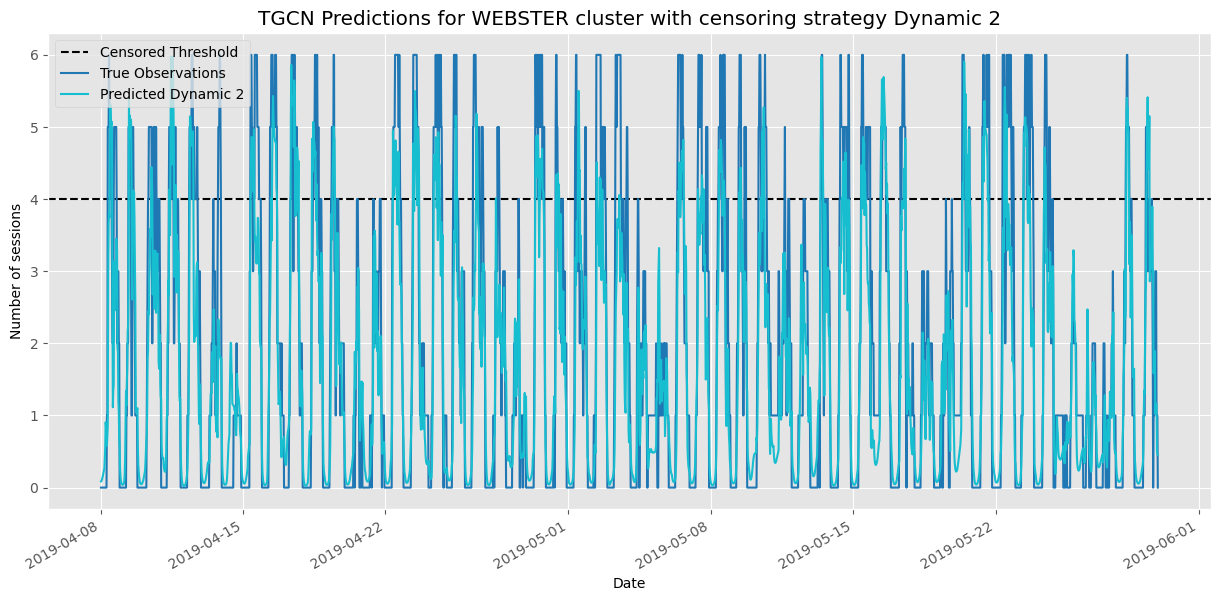

In [96]:
plot_predictions(df, 2, "Dynamic")

Max number of daily sessions

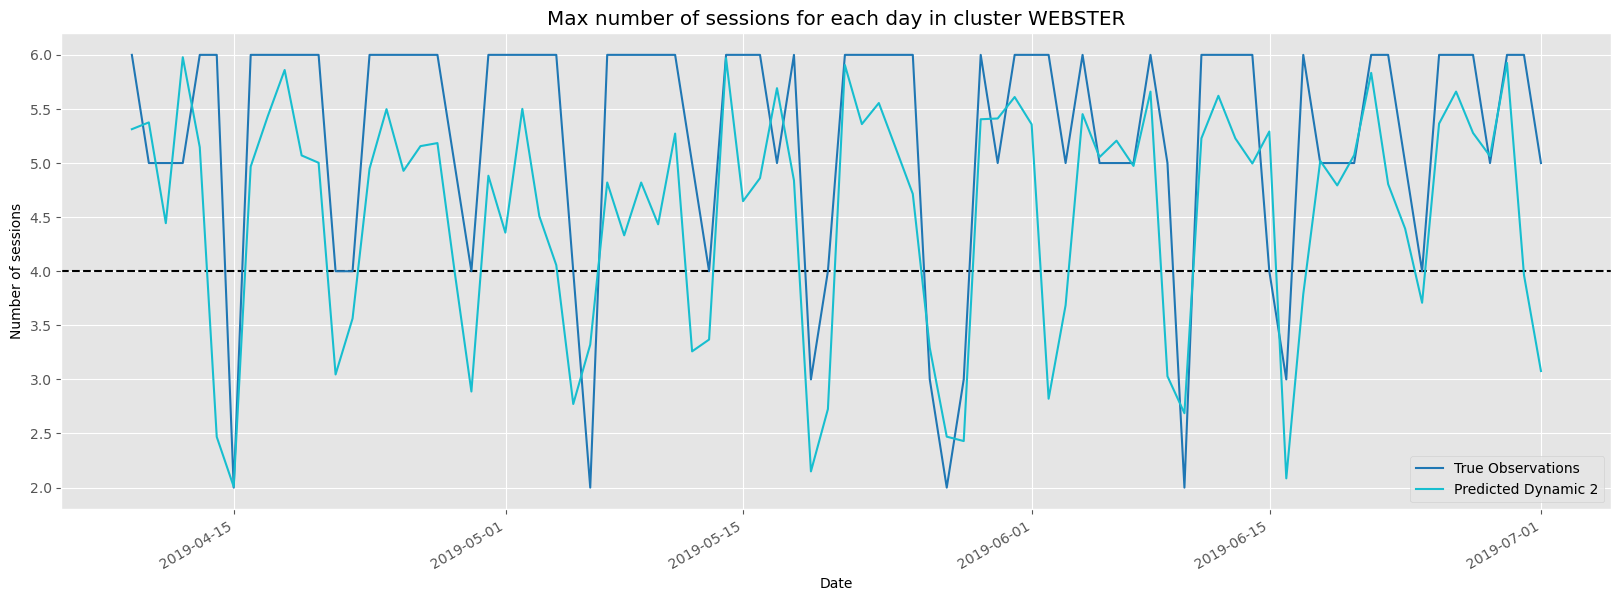

In [97]:
plot_daily_max_sessions(df, 2, "Dynamic")


Daily utilisation

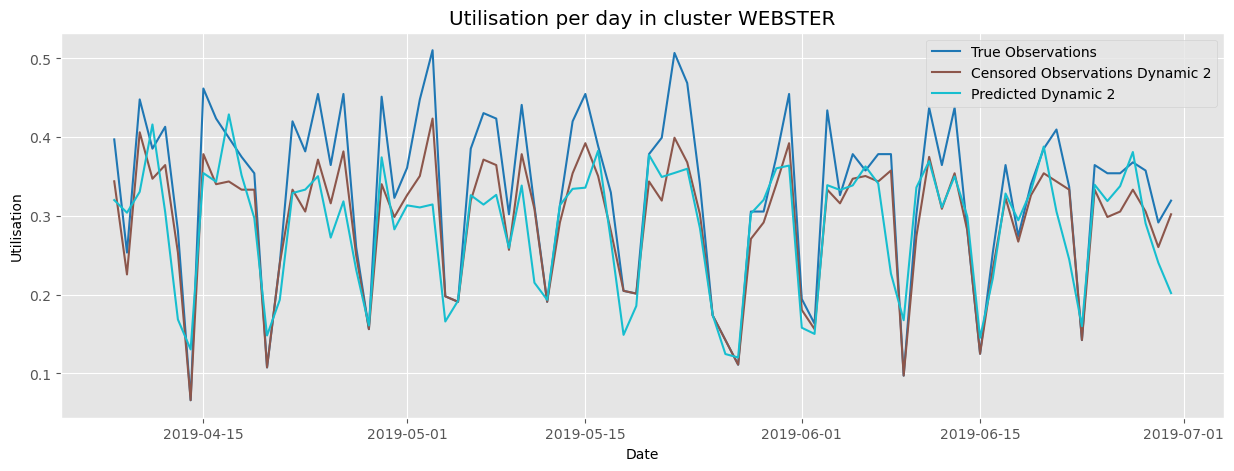

In [98]:
plot_utilisation_per_day(df, 2, "Dynamic")

Predicted mean utilisation for each strategy and the actual utilisation

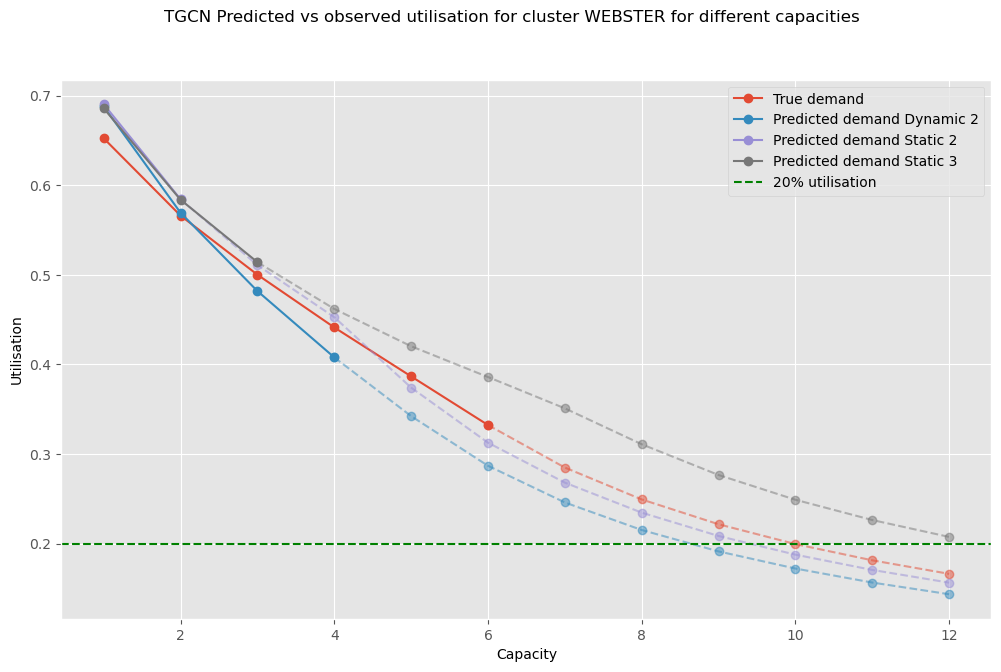

In [99]:
ax = plot_utility(df, 12, 2, "Dynamic")
# ax = plot_utility(df, 12, 1, "Dynamic")
ax = plot_utility(df, 12, 2, "Static", ax=ax)
ax = plot_utility(df, 12, 3, "Static", ax=ax)


ax.axhline(y=0.2, linestyle='--', color='g', label="20% utilisation")
plt.legend()
plt.show()

Once an EV-charging station is built, all costs are essentially fixed, so utilization is key to achieving efficiency. Still, even a quite low utilization is likely to result in lines at busy times. In practice, the stand-alone, fast-charger industry uses a 20% utilization as a rule of thumb. But if a charging station is utilized at more than this 20% threshold, the operator will likely look to expand capacity or, more likely, add another site nearby.

### 24 hours forecast lead

Load predictions

In [100]:
df_48 = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True, forecast_lead=48, aware=True, cluster='WEBSTER')
# df_48 = add_censoring_strategy_predictions(df_48, 1, "Dynamic", prefix="forecast_48_aware", cluster='WEBSTER')
df_48 = add_censoring_strategy_predictions(df_48, 2, "Static", forecast_lead=48, aware=True, cluster='WEBSTER')
df_48 = add_censoring_strategy_predictions(df_48, 3, "Static", forecast_lead=48, aware=True, cluster='WEBSTER')

df_48.head()

,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,No. Plugs per Hub,Cluster,Censored Observations Static 2,Predicted Static 2,Censored Observations Static 3,Predicted Static 3
Date,,,,,,,,,
2019-04-09 00:00:00,0.0,0.208776,0.0,6,WEBSTER,0.0,0.355583,0.0,0.224057
2019-04-09 00:30:00,0.0,0.169349,0.0,6,WEBSTER,0.0,0.293337,0.0,0.187758
2019-04-09 01:00:00,0.0,0.144164,0.0,6,WEBSTER,0.0,0.245874,0.0,0.162823
2019-04-09 01:30:00,0.0,0.129960,0.0,6,WEBSTER,0.0,0.211342,0.0,0.147034
2019-04-09 02:00:00,0.0,0.124426,0.0,6,WEBSTER,0.0,0.187379,0.0,0.138841


Max number of daily sessions

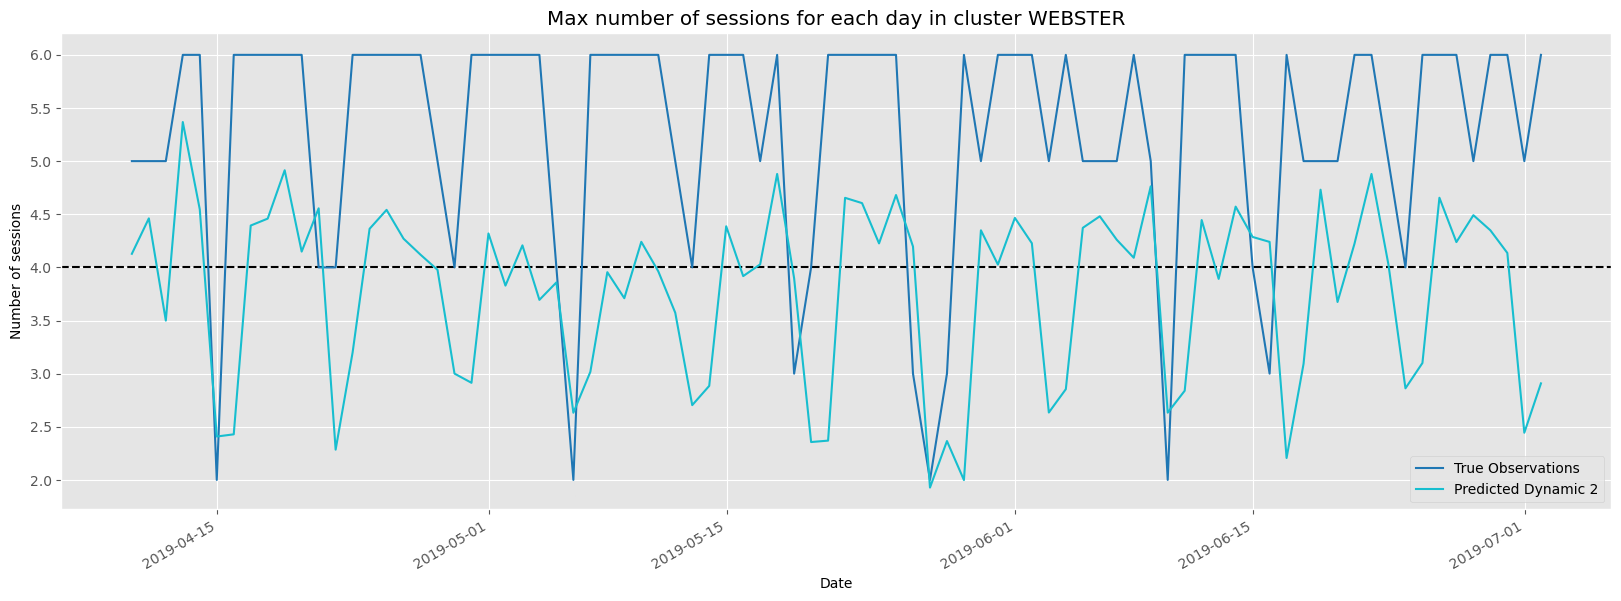

In [101]:
plot_daily_max_sessions(df_48.reset_index(), 2, "Dynamic")

Utilisation plot

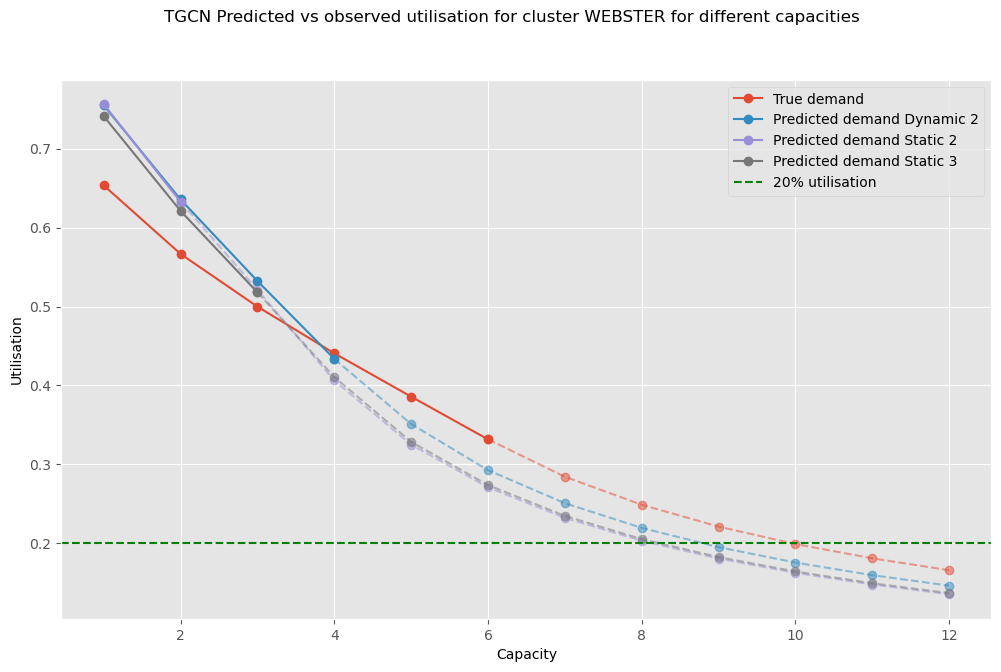

In [102]:
ax = plot_utility(df_48.reset_index(), 12, 2, "Dynamic")
#ax = plot_utility(df_48.reset_index(), 12, 1, "Dynamic", ax=ax)
ax = plot_utility(df_48.reset_index(), 12, 2, "Static", ax=ax)
ax = plot_utility(df_48.reset_index(), 12, 3, "Static", ax=ax)


ax.axhline(y=0.2, linestyle='--', color='g', label="20% utilisation")
plt.legend()
plt.show()

### 24 hours forecast lead plotted together with unaware model

In [103]:
df_48.head()
CLUSTER = 'WEBSTER' # Cluster for which we want to plot the predictions aware vs unaware

In [105]:
df_48_unaware = add_censoring_strategy_predictions(None, 3, "Static", forecast_lead=48, aware=False, cluster=CLUSTER, keep_obs=True)
# As we're not using a censored dataset
df_48_unaware["True Observations"] = df_48_unaware["Censored Observations Static 3"]
df_48_unaware["No. Plugs per Hub"] = PLUGS_PER_CLUSTER[CLUSTER]

df_48_unaware.head()

,Censored Observations Static 3,Predicted Static 3,True Observations,No. Plugs per Hub,Cluster
Date,,,,,
2019-04-09 00:00:00,0.0,0.190993,0.0,6,WEBSTER
2019-04-09 00:30:00,0.0,0.166549,0.0,6,WEBSTER
2019-04-09 01:00:00,0.0,0.152536,0.0,6,WEBSTER
2019-04-09 01:30:00,0.0,0.146217,0.0,6,WEBSTER
2019-04-09 02:00:00,0.0,0.145955,0.0,6,WEBSTER


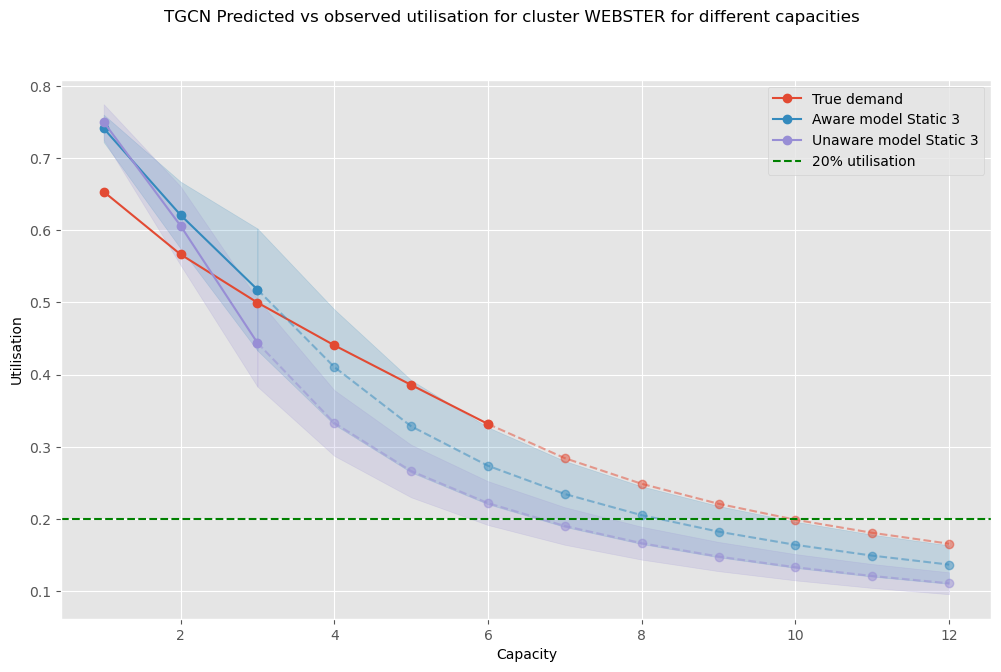

In [106]:
# Plot aware
ax = plot_utility(df_48.reset_index(), 12, 3, "Static", plot_std=True)
ax.lines[-2].set_label("Aware model Static 3")
# Plot unaware
ax = plot_utility(df_48_unaware.reset_index(), 12, 3, "Static", ax=ax, plot_std=True)
# Change label of the last plot
ax.lines[-2].set_label("Unaware model Static 3")
ax.axhline(y=0.2, linestyle='--', color='g', label="20% utilisation")
plt.legend()
plt.savefig(f"../Figures/aware_vs_unaware_{CLUSTER}.png", bbox_inches='tight')
plt.show()

In [107]:
df_48_unaware.head()

,Censored Observations Static 3,Predicted Static 3,True Observations,No. Plugs per Hub,Cluster
Date,,,,,
2019-04-09 00:00:00,0.0,0.190993,0.0,6,WEBSTER
2019-04-09 00:30:00,0.0,0.166549,0.0,6,WEBSTER
2019-04-09 01:00:00,0.0,0.152536,0.0,6,WEBSTER
2019-04-09 01:30:00,0.0,0.146217,0.0,6,WEBSTER
2019-04-09 02:00:00,0.0,0.145955,0.0,6,WEBSTER


Time series plot

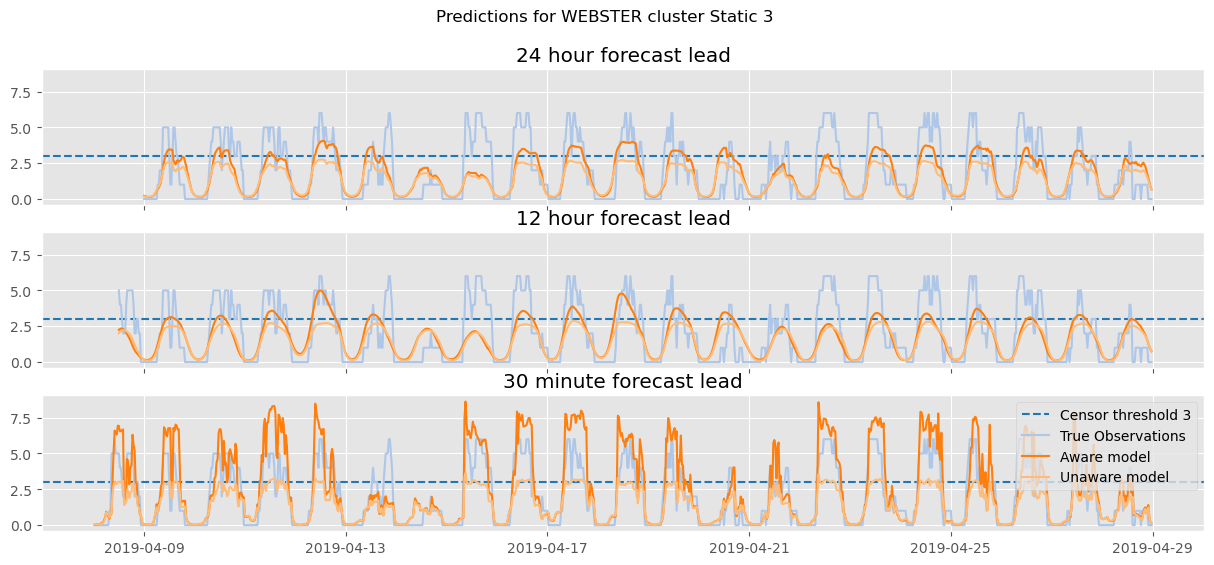

In [108]:
import matplotlib.pyplot as plt

def plot_forecast(ax, forecast_lead, title, strategy='Static', censor_level=3, cluster='WEBSTER', max_date='2019-04-29'):
    df_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster=cluster)
    df_aware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster=cluster, keep_obs=True)

    df_unaware_plot = df_unaware.copy().reset_index()
    df_unaware_plot = df_unaware_plot[df_unaware_plot.Date < max_date]

    df_aware_plot = df_aware.copy().reset_index()
    df_aware_plot = df_aware_plot[df_aware_plot.Date < max_date]

    # Plot y=3
    if strategy == 'Static':
        y = censor_level
    else:
        y = np.maximum(2, PLUGS_PER_CLUSTER[cluster] - censor_level)
    ax.axhline(y=y, linestyle='--', color=cmap(0), label=f"Censor threshold {y}")

    ax.plot(df_aware_plot.Date, df_aware_plot["True Observations"], color=cmap(1), label="True Observations")
    ax.plot(df_aware_plot.Date, df_aware_plot[f"Predicted {strategy} {censor_level}"], color=cmap(2), label="Aware model")
    # Plot unaware
    ax.plot(df_unaware_plot.Date, df_unaware_plot[f"Predicted {strategy} {censor_level}"], color=cmap(3), label="Unaware model")

fig, ax = plt.subplots(3, figsize=(15, 6), sharex=True, sharey=True)

# set title

# define colormap
cmap = plt.get_cmap("tab20")

max_date = '2019-04-29' # 2 weeks
CLUSTER = 'WEBSTER'

fig.suptitle(f"Predictions for {CLUSTER} cluster Static 3")

forecast_leads = [48, 24, 1]
titles = ["24 hour forecast lead", "12 hour forecast lead", "30 minute forecast lead"]

for i in range(3):
    ax[i].set_title(titles[i])
    plot_forecast(ax[i], forecast_leads[i], titles[i], cluster=CLUSTER)

ax[2].legend()

plt.show()


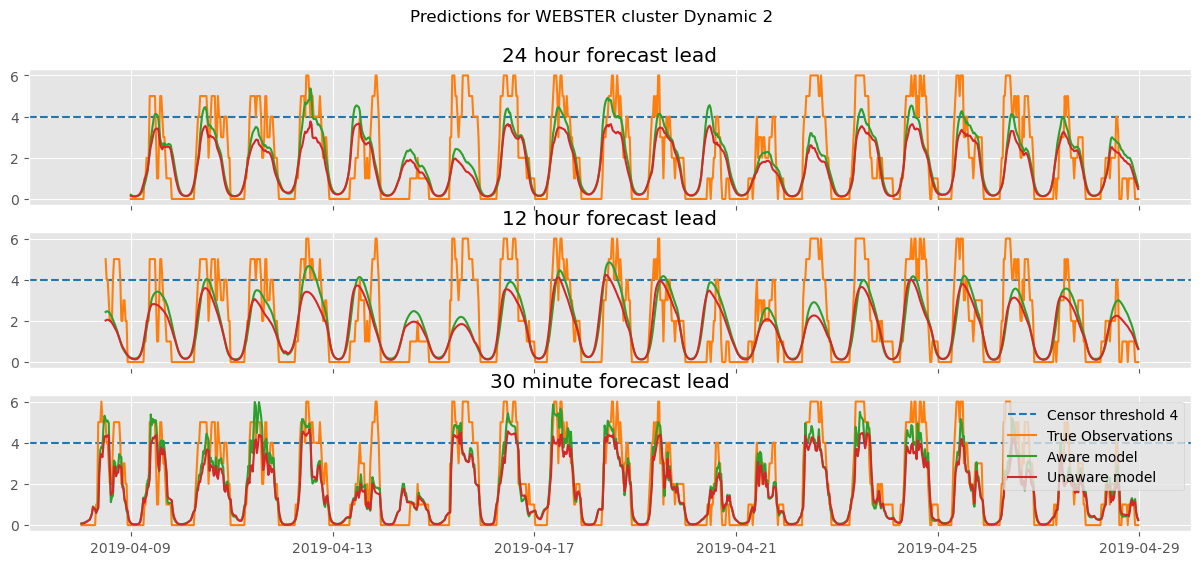

In [109]:
fig, ax = plt.subplots(3, figsize=(15, 6), sharex=True, sharey=True)

# set title
fig.suptitle(f"Predictions for {CLUSTER} cluster Dynamic 2")

# define colormap
cmap = plt.get_cmap("tab10")

max_date = '2019-04-29' # 2 weeks

forecast_leads = [48, 24, 1]
titles = ["24 hour forecast lead", "12 hour forecast lead", "30 minute forecast lead"]

for i in range(3):
    ax[i].set_title(titles[i])
    plot_forecast(ax[i], forecast_leads[i], titles[i], strategy='Dynamic', censor_level=2, cluster=CLUSTER)

ax[2].legend()

plt.show()

## Aggregation of macro-clusters

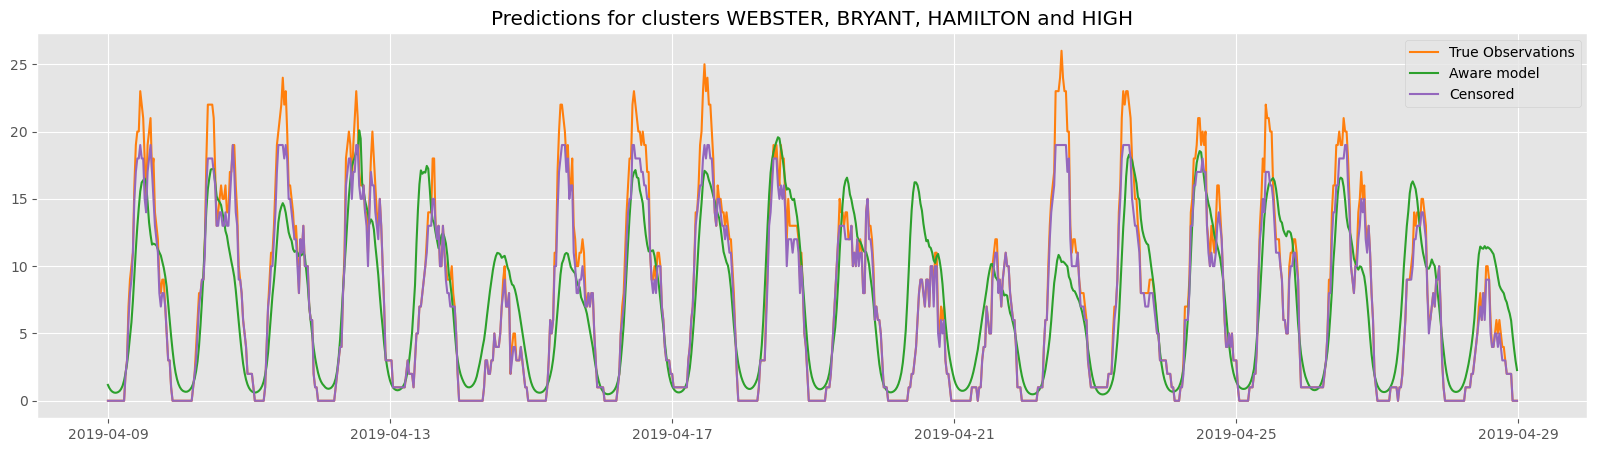

In [83]:
forecast_lead = 48

df_webster = add_censoring_strategy_predictions(None, 2, 'Dynamic', forecast_lead=forecast_lead, aware=True, cluster='WEBSTER', keep_obs=True)
df_bryant = add_censoring_strategy_predictions(None, 2, 'Dynamic', forecast_lead=forecast_lead, aware=True, cluster='BRYANT', keep_obs=True)
df_hamilton = add_censoring_strategy_predictions(None, 2, 'Dynamic', forecast_lead=forecast_lead, aware=True, cluster='HAMILTON', keep_obs=True)
df_high = add_censoring_strategy_predictions(None, 2, 'Dynamic', forecast_lead=forecast_lead, aware=True, cluster='HIGH', keep_obs=True)

df_total = pd.concat([df_webster, df_bryant, df_hamilton, df_high]).groupby('Date').sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 5))

df_total = df_total[df_total.Date < '2019-04-29']
# ax.axhline(y=26 - 4*2, linestyle='--', color=cmap(0), label=f"Censor threshold")
ax.set_title("Predictions for clusters WEBSTER, BRYANT, HAMILTON and HIGH")
ax.plot(df_total.Date, df_total["True Observations"], color=cmap(1), label="True Observations")
ax.plot(df_total.Date, df_total[f"Predicted Dynamic 2"], color=cmap(2), label="Aware model")
ax.plot(df_total.Date, df_total[f"Censored Observations Dynamic 2"], color=cmap(4), label="Censored")
ax.legend()
plt.show()

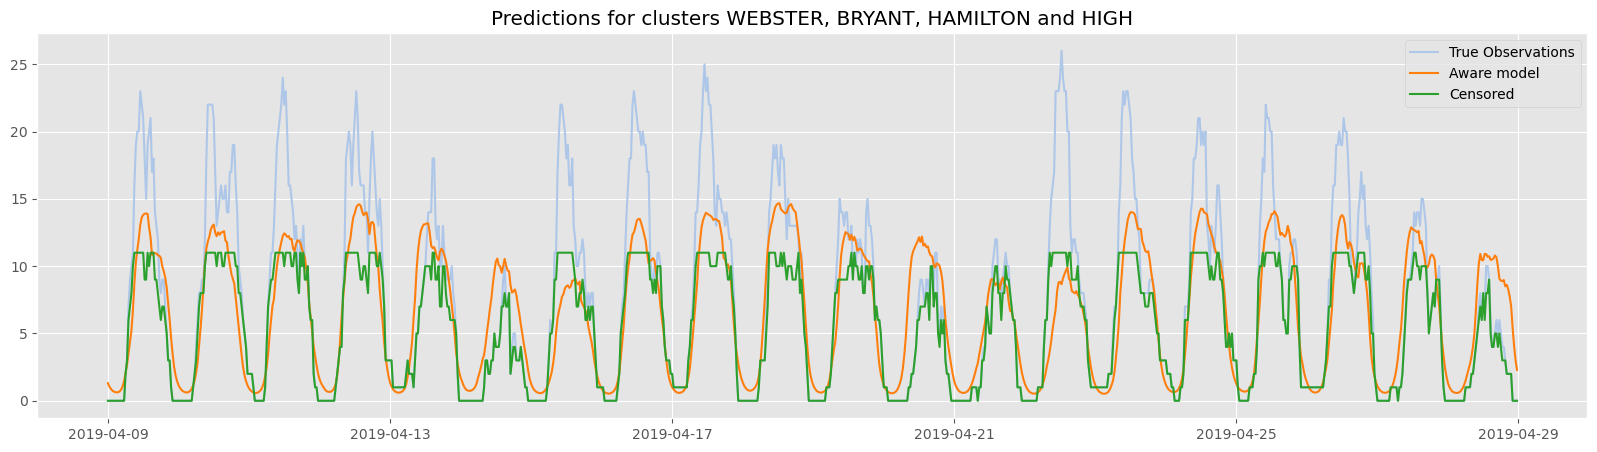

In [91]:
df_webster = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='WEBSTER', keep_obs=True)
df_bryant = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='BRYANT', keep_obs=True)
df_hamilton = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='HAMILTON', keep_obs=True)
df_high = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='HIGH', keep_obs=True)

df_total = pd.concat([df_webster, df_bryant, df_hamilton, df_high]).groupby('Date').sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 5))

df_total = df_total[df_total.Date < '2019-04-29']
# ax.axhline(y=26 - 4*2, linestyle='--', color=cmap(0), label=f"Censor threshold")
ax.set_title("Predictions for clusters WEBSTER, BRYANT, HAMILTON and HIGH")

ax.plot(df_total.Date, df_total["True Observations"], color=cmap(1), label="True Observations")
ax.plot(df_total.Date, df_total[f"Predicted Static 3"], color=cmap(2), label="Aware model")
ax.plot(df_total.Date, df_total[f"Censored Observations Static 3"], color=cmap(4), label="Censored")
ax.legend()
plt.show()

## 24 hour vs 30 min forecast
For Dynamic 2 

In [110]:
CLUSTER = 'CAMBRIDGE'

In [111]:
df_24_vs_30 = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True, forecast_lead=1, aware=True, cluster=CLUSTER)

df_24_vs_30 = df_24_vs_30.add_suffix('_forecast_1')
df_24_vs_30 = df_24_vs_30.rename(columns={'True Observations_forecast_1': 'True Observations'})
df_24_vs_30 = add_censoring_strategy_predictions(df_24_vs_30, 2, "Dynamic", forecast_lead=48, aware=True, cluster=CLUSTER)
df_24_vs_30["No. Plugs per Hub"] = PLUGS_PER_CLUSTER[CLUSTER]

df_24_vs_30.head()

,Censored Observations Dynamic 2_forecast_1,Predicted Dynamic 2_forecast_1,True Observations,No. Plugs per Hub_forecast_1,Cluster_forecast_1,Censored Observations Dynamic 2,Predicted Dynamic 2,No. Plugs per Hub
Date,,,,,,,,
2019-04-09 00:00:00,1.0,0.164207,1.0,10,CAMBRIDGE,1.0,0.371468,10
2019-04-09 00:30:00,1.0,0.164895,1.0,10,CAMBRIDGE,1.0,0.308374,10
2019-04-09 01:00:00,1.0,0.179024,1.0,10,CAMBRIDGE,1.0,0.263960,10
2019-04-09 01:30:00,1.0,0.206836,1.0,10,CAMBRIDGE,1.0,0.234894,10
2019-04-09 02:00:00,1.0,0.248697,1.0,10,CAMBRIDGE,1.0,0.218540,10


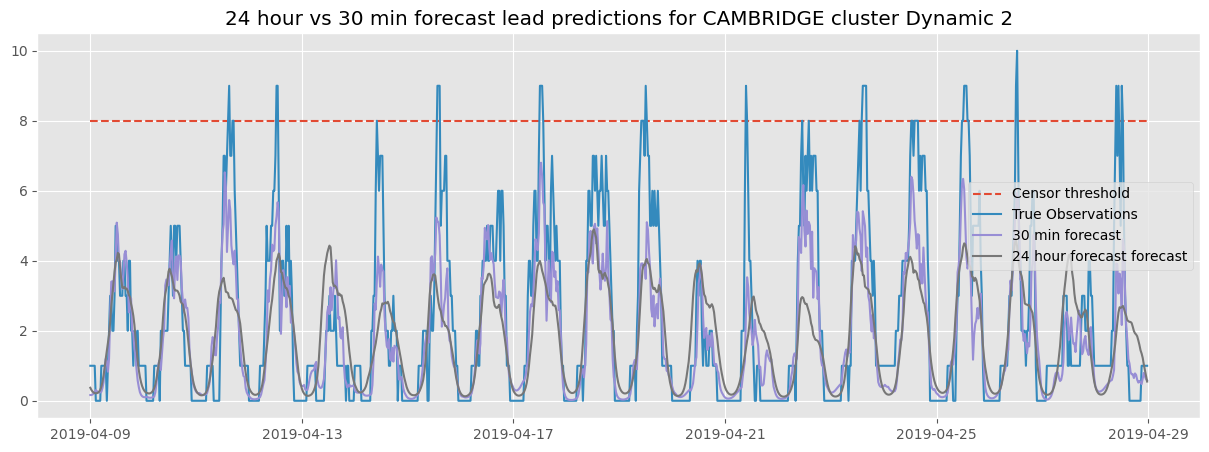

In [112]:
fig, ax = plt.subplots(figsize=(15, 5))
max_date = '2019-04-29' # 2 weeks
df_24_vs_30_plot = df_24_vs_30.copy().reset_index()
df_24_vs_30_plot = df_24_vs_30_plot[df_24_vs_30_plot.Date < max_date]


plt.plot(
    df_24_vs_30_plot.Date, np.minimum(3, df_24_vs_30_plot["No. Plugs per Hub"] - 2), # Dynamic 2
    linestyle='--', label="Censor threshold") 
plt.plot(df_24_vs_30_plot.Date, df_24_vs_30_plot["True Observations"], label="True Observations")
plt.plot(df_24_vs_30_plot.Date, df_24_vs_30_plot["Predicted Dynamic 2_forecast_1"], label="30 min forecast")
plt.plot(df_24_vs_30_plot.Date, df_24_vs_30_plot["Predicted Dynamic 2"], label="24 hour forecast forecast")

# Set horizontal line at the maximum number of plugs
ax.set_title(f"24 hour vs 30 min forecast lead predictions for {CLUSTER} cluster Dynamic 2")
ax.legend()
plt.show()

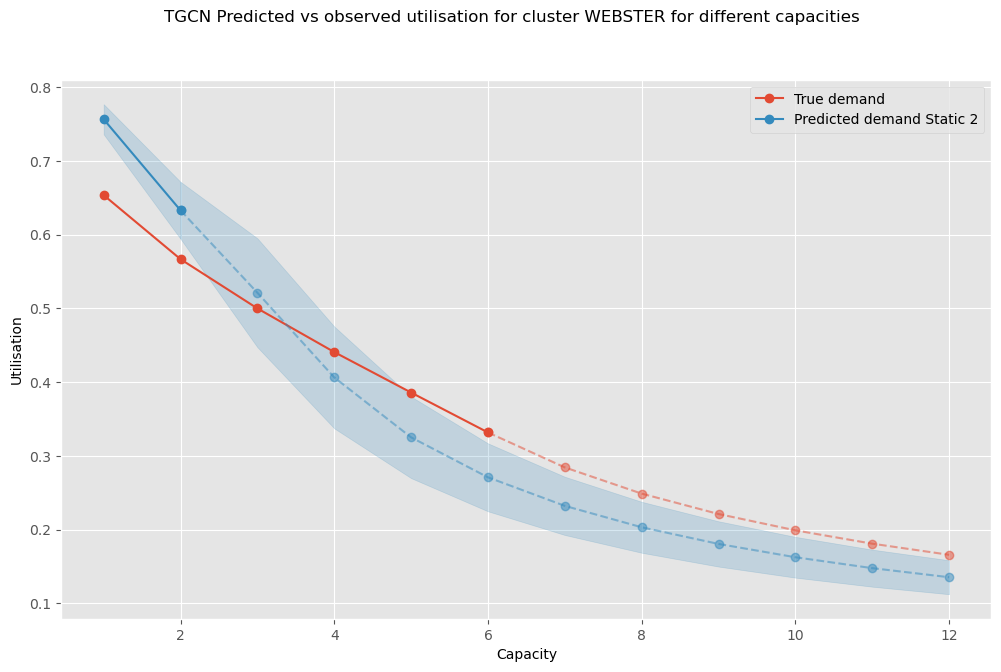

In [113]:
ax = plot_utility(df_48.reset_index(), 12, 2, "Static", plot_std=True)